In [ ]:
import numpy as np
import keras
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tqdm import tqdm

### Rearrange data and define loader functions

In [ ]:
image_data_path = './drive/MyDrive/Brain Tumour/Task01_BrainTumour/imagesTr/'
label_data_path = './drive/MyDrive/Brain Tumour/Task01_BrainTumour/labelsTr/'

image_paths = [image_data_path + name 
               for name in os.listdir(image_data_path) 
               if not name.startswith(".")]

label_paths = [label_data_path + name
               for name in os.listdir(label_data_path)
               if not name.startswith(".")]

image_paths = sorted(image_paths)
label_paths = sorted(label_paths)

len(image_paths), len(label_paths)

(484, 484)

In [ ]:
start_layer = 7
end_layer = 146 # 140
start_height = 34
end_height = 203 # 170
start_width = 20
end_width = 209 # 190

In [ ]:
def load_one_sample(image_path, label_path):

  image = nib.load(image_path).get_fdata().astype('float32')
  label = nib.load(label_path).get_fdata().astype(np.int64)  # the original dtype is float64

  return image, label

def preprocess_from_path(image_path, label_path):

  image, label = load_one_sample(image_path, label_path)

  image = image[start_height:end_height+1, start_width:end_width+1, start_layer:end_layer+1, :]
  image = np.reshape(image, (170, 190, 140 * 4))
  image = [cv2.resize(image[:, :, i], (95, 85)) for i in range(560)]
  image = np.reshape(image, (140, 4, 85, 95))
  image = np.moveaxis(image, 1, 3)

  label = label[start_height:end_height+1, start_width:end_width+1, start_layer:end_layer+1]
  label = [cv2.resize(label[:, :, i] + np.ones((170, 190)), (95, 85)) for i in range(140)]
  label = [np.array(label)[i, :, :] - np.ones((85, 95)) for i in range(140)]
  label = np.array(label)
  label = np.expand_dims(label, 3).astype(np.int64)

  return image, label

(140, 85, 95, 4) (140, 85, 95, 1) <class 'numpy.ndarray'>


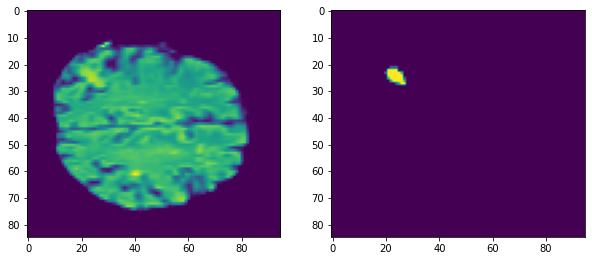

In [ ]:
image_example, label_example = preprocess_from_path(image_paths[9], label_paths[9])
print(image_example.shape, label_example.shape, type(label_example))

plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_example[100, :, :, 0])
plt.subplot(1, 2, 2)
plt.imshow(label_example[100, :, :, 0])

In [ ]:
label_example

### TFRecord

In [ ]:
def image_feature(value):
  return tf.train.Feature(bytes_list = tf.train.BytesList(value = value)) ##

def float_feature(value):
  return tf.train.Feature(float_list = tf.train.FloatList(value = value))

def int64_feature(value):
  return tf.train.Feature(int64_list = tf.train.Int64List(value = value))

def create_example(image_path, label_path):
  image, label = preprocess_from_path(image_path, label_path)
  image, label = image.ravel(), label.ravel()
  feature = {'image': float_feature(image),
             'label': int64_feature(label)}
  example = tf.train.Example(features = tf.train.Features(feature = feature))
  return example

def parse_tfrecord(example):
  feature = {'image': tf.io.FixedLenFeature([140, 85, 95, 4], tf.float32),
             'label': tf.io.FixedLenFeature([140, 85, 95, 1], tf.int64)}
  parsed_example = tf.io.parse_single_example(example, feature)
  return parsed_example

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
train_writer = tf.io.TFRecordWriter('train.tfrecords')
valid_writer = tf.io.TFRecordWriter('valid.tfrecords')

for i in range(1,2):
  example = create_example(image_paths[i], label_paths[i])
  train_writer.write(example.SerializeToString())
train_writer.close()

for i in range(2,3):
  example = create_example(image_paths[i], label_paths[i])
  valid_writer.write(example.SerializeToString())
valid_writer.close()

serialised_train_set = tf.data.TFRecordDataset('train.tfrecords')
serialised_valid_set = tf.data.TFRecordDataset('valid.tfrecords')

serialised_train_set = serialised_train_set.map(parse_tfrecord)
serialised_valid_set = serialised_valid_set.map(parse_tfrecord)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


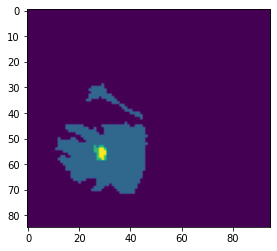

In [ ]:
for features in serialised_valid_set.take(100):
  plt.imshow(features['label'][90, :, :, 0])

In [ ]:
for features in serialised_valid_set.take(100):
  print(features['label'].shape)

(140, 85, 95, 1)


### Model

In [ ]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Rescaling

num_classes = 4

unet_beginner_version = tf.keras.Sequential([

Input(shape = (85, 95, 4), name = 'image'),
Rescaling(scale = 1./255),
Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same'),
Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same'),
Conv2D(filters = 128, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same'),
Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'),
Conv2D(filters = 256, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same'),
Conv2D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same'),
Conv2D(filters = 512, kernel_size = 3, activation = 'relu', strides = 1, padding = 'same'),
Conv2D(filters = 512, kernel_size = 3, activation = 'relu', padding = 'same'),
Conv2D(filters = 1024, kernel_size = 3, activation = 'relu', strides = 1, padding = 'same'),
Conv2D(filters = 1024, kernel_size = 3, activation = 'relu', padding = 'same'),

Conv2DTranspose(filters = 1024, kernel_size = 3, activation = 'relu', padding = 'same'),
Conv2DTranspose(filters = 1024, kernel_size = 3, activation = 'relu', strides = 1, padding = 'same'),
Conv2DTranspose(filters = 512, kernel_size = 3, activation = 'relu', padding = 'same'),
Conv2DTranspose(filters = 512, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same'),
Conv2DTranspose(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same'),
Conv2DTranspose(filters = 256, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same'),
Conv2DTranspose(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'),
Conv2DTranspose(filters = 128, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same'),
Conv2DTranspose(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same'),
Conv2DTranspose(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same'),


Conv2D(filters = num_classes, kernel_size = 3, activation = 'softmax', padding = 'same')

])

In [ ]:
unet_beginner_version.summary()

In [ ]:
unet_beginner_version.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')

In [ ]:
def get_image_and_label(features):
  image, label = features['image'], features['label']
  return image, label

def get_dataset(tfrecord_names):

  dataset = (tf.data.TFRecordDataset(tfrecord_names)
             .map(parse_tfrecord)
             .map(get_image_and_label))

  return dataset

In [ ]:
train_set = get_dataset('train.tfrecords')
valid_set = get_dataset('valid.tfrecords')

callback = tf.keras.callbacks.ModelCheckpoint('drive/MyDrive/test.h5')

#unet_beginner_version = tf.keras.models.load_model('drive/MyDrive/test.h5')

history = unet_beginner_version.fit(train_set,
                          validation_data = valid_set,
                          callbacks = callback,
                          batch_size = 16,
                          epochs = 20)

Epoch 1/20


ResourceExhaustedError: ignored

In [ ]:
# unet_beginner_version = tf.keras.models.load_model('drive/MyDrive/test.h5')

In [ ]:
def show_result(image_path, label_path, layer):

  one_image, one_label = preprocess_from_path(image_path, label_path)
  predicted_label = unet_beginner_version.predict(np.expand_dims(one_image[layer, :, :, :], 0))[0]

  # plot and compare the result

  plt.figure(figsize = (20, 5))
  plt.subplot(1, 4, 1)
  plt.imshow(one_image[layer, :, :, 0])
  plt.axis('off')

  plt.subplot(1, 4, 2)
  plt.imshow(one_label[layer, :, :, 0])
  plt.axis('off')

  plt.subplot(1, 4, 3)
  plt.imshow(predicted_label[:, :, 3])
  plt.axis('off')

  plt.subplot(1, 4, 4)
  plt.imshow(np.argmax(predicted_label, axis = -1))
  plt.axis('off')

  plt.savefig('drive/MyDrive/mypic')

  return predicted_label


In [ ]:
predicted_label = show_result(image_paths[2], label_paths[2], 90)
predicted_label.shape

In [ ]:
plt.imshow(np.argmax(predicted_label, axis = 2))

### Testing

### **Check for informative range**

In [ ]:
def check_informative_layers_range_by_images(image_example):
  informative_layers = []
  for i in range(155):
    unique_numbers = np.unique(image_example[:, :, i, :])
    if len(unique_numbers) == 1:
      pass
    else:
      informative_layers.append(i)
  informative_layers_range = np.array([[informative_layers[0], informative_layers[-1]]])
  return informative_layers_range

def check_informative_layers_range_by_labels(label_example):
  informative_layers = []
  for i in range(155):
    unique_numbers = np.unique(label_example[:, :, i])
    if len(unique_numbers) == 1:
      pass
    else:
      informative_layers.append(i)
  informative_layers_range = np.array([[informative_layers[0], informative_layers[-1]]])
  return informative_layers_range

In [ ]:
def check_informative_height_range(image_example):
  informative_height_range = []
  for i in range(240):
    number_of_unique_numbers = len(np.unique(image_example[i, :, :, :]))
    if number_of_unique_numbers == 1:
      pass
    else:
      informative_height_range.append(i)
  informative_height_range = np.array([[informative_height_range[0], informative_height_range[-1]]])
  return informative_height_range

def check_informative_width_range(image_example):
  informative_width_range = []
  for i in range(240):
    number_of_unique_numbers = len(np.unique(image_example[:, i, :, :]))
    if number_of_unique_numbers == 1:
      pass
    else:
      informative_width_range.append(i)
  informative_width_range = np.array([[informative_width_range[0], informative_width_range[-1]]])
  return informative_width_range

In [ ]:
informative_layers_all_examples = np.empty((484, 2))
informative_height_all_examples = np.empty((484, 2))
informative_width_all_examples = np.empty((484, 2))

for i in range(484):
  
  image_example, label_example = load_one_sample(image_paths[i], label_paths[i])

  informative_layers_all_examples[i] = check_informative_layers_range_by_labels(label_example)
  informative_height_all_examples[i] = check_informative_height_range(image_example) 
  informative_width_all_examples[i] = check_informative_width_range(image_example)


KeyboardInterrupt: ignored

In [ ]:
acceptable_layer_range = [informative_layers_all_examples.min(axis = 0)[0], informative_layers_all_examples.max(axis = 0)[1]]
print('acceptable_layer_range', acceptable_layer_range)
acceptable_height_range = [informative_height_all_examples.min(axis = 0)[0], informative_height_all_examples.max(axis = 0)[1]]
print('acceptable_height_range', acceptable_height_range)
acceptable_width_range = [informative_width_all_examples.min(axis = 0)[0], informative_width_all_examples.max(axis = 0)[1]]
print('acceptable_width_range', acceptable_width_range)

In [ ]:
start_layer = informative_layers_all_examples.min(axis = 0)[0]
end_layer = informative_layers_all_examples.max(axis = 0)[1]

start_height = informative_height_all_examples.min(axis = 0)[0]
end_height = informative_height_all_examples.max(axis = 0)[1]

start_width = informative_width_all_examples.min(axis = 0)[0]
end_width = informative_width_all_examples.max(axis = 0)[1]

In [ ]:
start_layer = 7
end_layer = 145
start_height = 38
end_height = 199
start_width = 19
end_width = 210

In [ ]:
plt.figure(figsize = (15, 25))
for i in range(150):
  plt.subplot(15, 10, i+1)
  plt.imshow(image_example[53:189, 21:197, i, 0])
  plt.title(f'layer {i}')
  plt.axis('off')

In [ ]:
image_example, label_example = load_one_sample(image_paths[0], label_paths[0])
informative_layers = check_informative_layers_range_by_labels(label_example)
print('informative_layers', informative_layers)
informative_height_range = check_informative_height_range(image_example)
print('informative_height_range', informative_height_range)
informative_width_range = check_informative_width_range(image_example)
print('informative_width_range', informative_width_range)

### Next

In [ ]:
def preprocess(image_path, label_path):

  image, label = load_one_sample(image_path, label_path)

  image = image[start_height:end_height+1, start_width:end_width+1, start_layer:end_layer+1, :]
  image = tf.experimental.numpy.moveaxis(image, 2, 0)
  label = label[start_height:end_height+1, start_width:end_width+1, start_layer:end_layer+1]
  label = tf.experimental.numpy.moveaxis(label, 2, 0)

  return image, label

In [ ]:
num_layers = end_layer - start_layer + 1
height = end_height - start_height + 1
width = end_width - start_width + 1
train_images = np.empty((484 * num_layers, height, width, 4))

for i in tqdm(range(484)):

  image, _ = preprocess(image_paths[i], label_paths[i])
  train_images[num_layers * i : num_layers * (i+1)] = image

### Next next

In [ ]:
image_filenames = tf.constant(image_paths)
label_filenames = tf.constant(label_paths)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, label_filenames))

for image, label in dataset.take(1):
    print(image)
    print(label)

In [ ]:
def wrapper_load(img_path, label_path):
  img, label = tf.py_function(func = load_one_sample, inp = [img_path, label_path], Tout = [tf.float32, tf.uint8])
  return img, label

dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths)).map(wrapper_load)

In [ ]:
image_example.shape

### The model

In [ ]:
ten_labels = tf.keras.utils.to_categorical(ten_labels)

In [ ]:
from random import Random
# Random(1357).shuffle(ten_images)
# Random(1357).shuffle(ten_labels)

train_images = ten_images[:155 * 3]
train_labels = ten_labels[:155 * 3]
val_images = ten_images[-155 * 1:]
val_labels = ten_labels[-155 * 1:]

In [ ]:
train_images.shape, val_labels.shape

In [ ]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Rescaling, MaxPooling2D, Dropout

num_classes = 4

unet_beginner_version = tf.keras.Sequential([

Input(shape = (240, 240, 4)),
Rescaling(scale = 1./255),
Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same'),
Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same'),
Dropout(0.5),
Conv2D(filters = 128, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same'),
Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'),
Dropout(0.5),
Conv2D(filters = 256, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same'),
Conv2D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same'),


Conv2DTranspose(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same'),
Conv2DTranspose(filters = 256, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same'),
Conv2DTranspose(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'),
Conv2DTranspose(filters = 128, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same'),
Conv2DTranspose(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same'),
Conv2DTranspose(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same'),

Conv2D(filters = num_classes, kernel_size = 3, activation = 'softmax', padding = 'same')

])

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range = 45)
val_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range = 45)

aug_train_set = train_generator.flow(train_images, train_labels, batch_size = 32)
aug_val_set = val_generator.flow(val_images, val_labels, batch_size = 32)

steps_per_epoch = train_images.shape[0] // 32
validation_steps = val_images.shape[0] // 32

In [ ]:
unet_beginner_version.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001),
                              loss = 'categorical_crossentropy')

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("drive/MyDrive/Brain Tumour/draft.keras",
                                    save_best_only=True)]

In [ ]:
history = unet_beginner_version.fit(aug_train_set, steps_per_epoch = steps_per_epoch,
                                    validation_data = aug_val_set, validation_steps = validation_step,
                                    batch_size = 32,
                                    callbacks = [callbacks],
                                    epochs = 2)

In [ ]:
unet_beginner_version = tf.keras.models.load_model('drive/MyDrive/Brain Tumour/draft.keras')

In [ ]:
from tensorflow.keras.layers import *

def unet(input_size = (240, 240, 4)):

    inputs = Input(input_size)
    inputs = Rescaling(scale = 1./255)(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    # drop4 = Dropout(0.5)(conv4)
    # pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    # conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    # drop5 = Dropout(0.5)(conv5)

    drop5 = Dropout(0.5)(conv4)

    #up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    #merge6 = concatenate([drop4,up6], axis = 3)
    #conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    #conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    #up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(filters = 4, kernel_size = 1, activation = 'softmax')(conv9)

    model = tf.keras.models.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['mse'])

    return model

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("drive/MyDrive/Brain Tumour/draft.keras",
                                    save_best_only=True)]
model = unet(input_size = (240, 240, 4))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range = 45)
val_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range = 45)

aug_train_set = train_generator.flow(train_images, train_labels, batch_size = 32)
aug_val_set = val_generator.flow(val_images, val_labels, batch_size = 32)

steps_per_epoch = train_images.shape[0] // 32
validation_steps = val_images.shape[0] // 32

In [ ]:
history = model.fit(aug_train_set, steps_per_epoch = steps_per_epoch,
                              validation_data = aug_val_set, validation_steps = validation_steps,
                             batch_size = 32,
                              callbacks = callbacks,
                              epochs = 2)

Epoch 1/2
14/14 [==============================] - 2030s 145s/step - loss: 2.4522 - mse: 0.1874 - val_loss: 1.3830 - val_mse: 0.1871
Epoch 2/2
14/14 [==============================] - 2041s 146s/step - loss: 1.3812 - mse: 0.1653 - val_loss: 1.1773 - val_mse: 0.1583


In [ ]:
one_predicted_example = unet_beginner_version.predict(val_images[:155])

val_images[:155].shape, one_predicted_example.shape

((155, 240, 240, 4), (155, 240, 240, 4))

In [ ]:
one_predicted_example_label = np.argmax(one_predicted_example, axis = -1)
print(one_predicted_example_label.shape)
np.unique(one_predicted_example_label)

(155, 240, 240)


array([0, 1, 2])

(-0.5, 239.5, 239.5, -0.5)

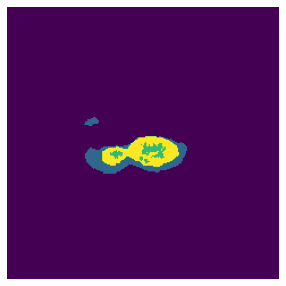

In [ ]:
plt.figure(figsize = (5, 5))
plt.imshow(np.argmax(val_labels[:155], axis = -1)[100, :, :])
plt.axis('off')

(-0.5, 239.5, 239.5, -0.5)

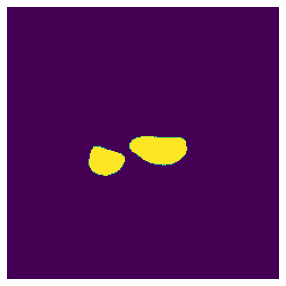

In [ ]:
plt.figure(figsize = (5, 5))
plt.imshow(one_predicted_example_label[100, :, :])
plt.axis('off')

In [ ]:
a = np.argmax(one_predicted_example, axis = -1)

### draft

In [ ]:
import scipy.stats as stats
stats.norm.cdf(1.5) - stats.norm.cdf(-1.5)
stats.norm.ppf(0.9) * 2 + 12

14.5631031310892